In [3]:
from pdf2image import convert_from_path
import os
import base64
import anthropic
from IPython.display import Image
import urllib.request

In [7]:
pdf_files = [f for f in os.listdir() if f.endswith('.pdf')]

In [45]:
with open("apikey.txt", 'r') as f:
    apikey = f.readline()[:-1]

In [47]:
client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=apikey,
)

model_str = "claude-3-5-sonnet-20240620"

prompt = """
היי!
אני צריך את עזרתך בחילוץ מידע מהחשבונית שבתמונה המצורפת.
אשמח אם תוכל לתת את כל הפרטים בפורמט json
עם השדות הבאים:

"vendor_name" - name of vendor
"vendor_num" - מספר עסק או ח.פ של הספק
"invoice number" - number of invoice
"price" - transaction price
"vat" - vat paid
"currency" - ILS or USD
"date" - date on invoice
"time" - time on invoice

PLEASE RESPONSE ONLY WITH THE REQUESTED JSON AND NOTHING ELSE
"""

def create_msg_with_img(prompt, encoded_img):
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": encoded_img
                    }
                },
                {
                    "type": "text",
                    "text": "\n\"invoice number\" - number of invoice\n\"price\" - transaction price\n\"vat\" - vat paid\n\"currency\" - ILS or USD\n\"date\" - date on invoice\n\"time\" - time on invoice"
                }
            ]
        }
    ]
    return messages

In [48]:
def convert_pdf_to_img(pdf_fname, img_fname, dpi=100):
    imgobj = convert_from_path(pdf_fname, single_file=True, dpi=dpi)[0]
    imgobj.save(img_fname, 'JPEG')
    print(f'Saved image at {img_fname}')
    return imgobj

def encode_base64_str(img_fname):
    with open(img_fname, "rb") as image_file:
        binary_data = image_file.read()
        base_64_encoded_data = base64.b64encode(binary_data)
        base64_string = base_64_encoded_data.decode('utf-8')
    return base64_string

def get_claude_resp(client, messages, model_str="claude-3-5-sonnet-20240620", max_tokens=1000):
    response = client.messages.create(
        model=model_str,
        max_tokens=max_tokens,
        temperature=0,
        messages=messages
    )
    return response.content[0].text


Saved image at invoice.jpg
Sent data to claude API, waiting for response...
Response time: 4.295s
{
  "vendor_name": "RE/MAX לב הארץ",
  "vendor_num": "056103039",
  "invoice_number": "694",
  "price": 4329.00,
  "vat": 629.00,
  "currency": "ILS",
  "date": "13/11/2022",
  "time": ""
}
--------------


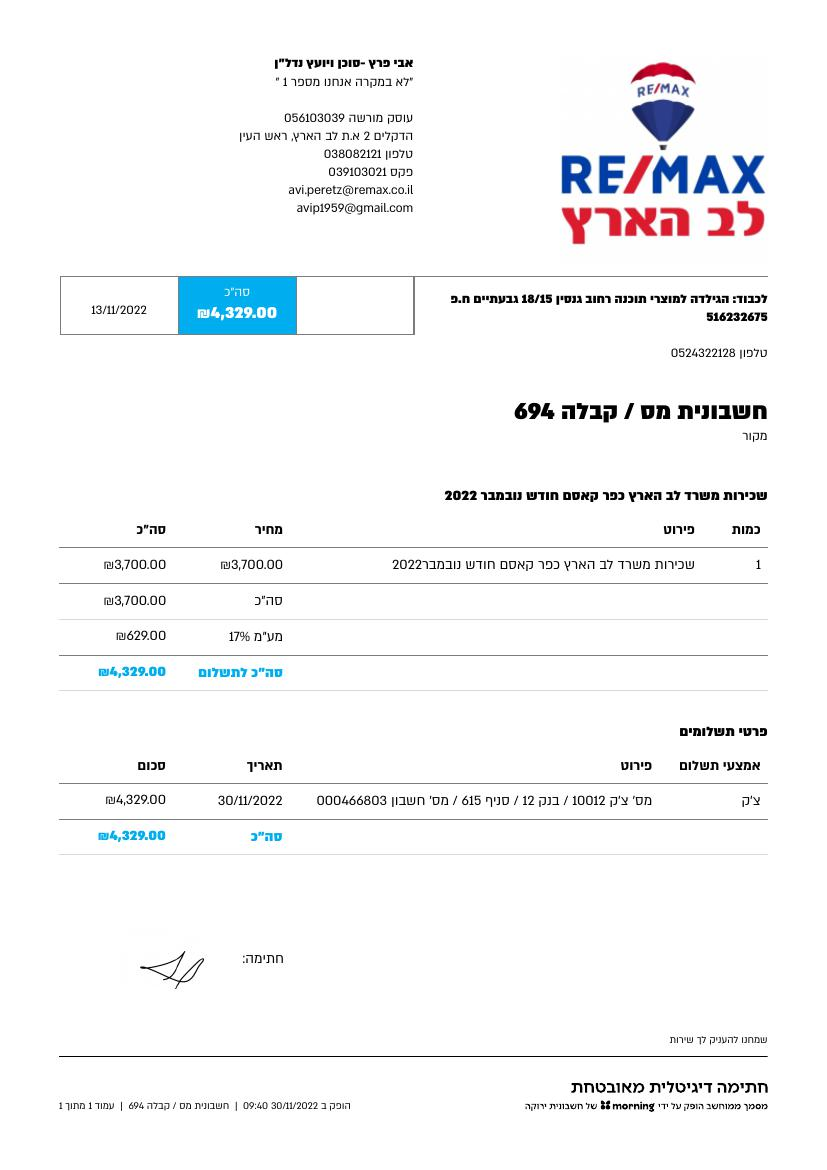

In [49]:
from IPython.display import Image
import time

pdf_url = 'http://res.cloudinary.com/gilgardosh/image/upload/v1670235360/sxursybiqvma2f4vm4cq.pdf'
pdf_fname = 'invoice.pdf'
urllib.request.urlretrieve(pdf_url, pdf_fname)
# pdf_fname = pdf_files[0]  # 'kye6ebvkv1h5drlusmf5.pdf'
img_fname = pdf_fname.replace('.pdf', '.jpg')
imgobj = convert_pdf_to_img(pdf_fname, img_fname)  # convert pdf to img
img_encoded = encode_base64_str(img_fname)

claude_msg = create_msg_with_img(prompt, img_encoded)
print('Sent data to claude API, waiting for response...')
start_time = time.time()
resp = get_claude_resp(client, claude_msg)
end_time = time.time()
print(f"Response time: {end_time - start_time:.3f}s")
print(resp)
print('--------------')
Image(img_fname)



In [ ]:
# http://res.cloudinary.com/gilgardosh/image/upload/v1670235360/sxursybiqvma2f4vm4cq.pdf
# http://res.cloudinary.com/gilgardosh/image/upload/v1637770436/dnd8tiz9rhfsfagkxjey.pdf
# http://res.cloudinary.com/gilgardosh/image/upload/v1649606554/kye6ebvkv1h5drlusmf5.pdf
# http://res.cloudinary.com/gilgardosh/image/upload/v1699548909/ch6xvmh4mjalpk8rgacm.pdf
# http://res.cloudinary.com/gilgardosh/image/upload/v1718640445/xmrwnpqpjfzyzpges32i.pdf

In [ ]:
# # ---- without saving temp file ----

# from PIL import Image
# import io
# import base64

# # without saving temp file
# buffer = io.BytesIO()
# ii[0].save(buffer, format='JPEG')
# base_64_encoded_data = base64.b64encode(buffer.getvalue())
# base64_string = base_64_encoded_data.decode('utf-8')